In [1]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv(r"C:\Users\yale3\OneDrive\바탕 화면\대학\3학년2학기\기학프\Alcohol_Sales.csv")
data = df['S4248SM144NCEN'].values.reshape(-1,1)


In [2]:
# 2. 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [3]:
# 3. 시퀀스 생성
window = 12   # 최근 12개월 → 다음달 예측
X, y = [], []
for i in range(len(data)-window):
    X.append(data[i:i+window])
    y.append(data[i+window])
X, y = np.array(X), np.array(y)



In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(window,1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])


c:\Users\yale3\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# 6. Train/Test 분할 (누수 방지) + 시퀀스 생성
# /test=70/30, window=12 기준
from sklearn.preprocessing import MinMaxScaler

window = 12  # 필요 시 조정
train_ratio = 0.7
val_ratio = 0.1  # 검증 비율
series = df['S4248SM144NCEN'].values.reshape(-1, 1)
split_idx_train = int(len(series) * train_ratio)
split_idx_val = int(len(series) * (train_ratio + val_ratio))

scaler_ts = MinMaxScaler()
train_raw = series[:split_idx_train]
val_raw_start = max(0, split_idx_train - window)
val_raw = series[val_raw_start:split_idx_val]
test_raw_start = max(0, split_idx_val - window)
test_raw = series[test_raw_start:]

train_scaled = scaler_ts.fit_transform(train_raw)
val_scaled = scaler_ts.transform(val_raw)
test_scaled = scaler_ts.transform(test_raw)

def make_sequences(arr, win):
    X, y = [], []
    for i in range(win, len(arr)):
        X.append(arr[i - win:i])
        y.append(arr[i])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_scaled, window)
X_val,  y_val  = make_sequences(val_scaled, window)
X_test, y_test = make_sequences(test_scaled, window)

print('훈련 데이터의 크기 :', X_train.shape, y_train.shape)
print('검증 데이터의 크기 :', X_val.shape, y_val.shape)
print('테스트 데이터의 크기 :', X_test.shape, y_test.shape)


훈련 데이터의 크기 : (215, 12, 1) (215, 1)
검증 데이터의 크기 : (33, 12, 1) (33, 1)
테스트 데이터의 크기 : (65, 12, 1) (65, 1)


In [6]:
# 7. 모델 A: RNN (SimpleRNN) 학습 및 MSE 평가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanSquaredError

rnn_model = Sequential([
    SimpleRNN(20, activation='tanh', return_sequences=True, input_shape=X_train.shape[1:]),
    Dropout(0.3),
    SimpleRNN(20, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
rnn_model.summary()

hist_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=50, batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)
rnn_mse = rnn_model.evaluate(X_test, y_test, verbose=0)[0]
print(f'RNN Test MSE: {rnn_mse:.6f}')
pred_rnn = rnn_model.predict(X_test)


c:\Users\yale3\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 12, 20)         │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1955 - mse: 0.1955 - val_loss: 0.1788 - val_mse: 0.1788
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1293 - mse: 0.1293 - val_loss: 0.0449 - val_mse: 0.0449
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1110 - mse: 0.1110 - val_loss: 0.1002 - val_mse: 0.1002
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1034 - mse: 0.1034 - val_loss: 0.0439 - val_mse: 0.0439
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0585 - mse: 0.0585 - val_loss: 0.0416 - val_mse: 0.0416
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0463 - mse:

In [7]:
# 8. 모델 B: LSTM 학습 및 MSE 평가
lstm_model = Sequential([
    LSTM(20, activation='tanh', return_sequences=True, input_shape=X_train.shape[1:]),
    Dropout(0.3),
    LSTM(20, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
lstm_model.summary()

hist_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50, batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)
lstm_mse = lstm_model.evaluate(X_test, y_test, verbose=0)[0]
print(f'LSTM Test MSE: {lstm_mse:.6f}')
pred_lstm = lstm_model.predict(X_test)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0908 - mse: 0.0908 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0579 - val_mse: 0.0579
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.021

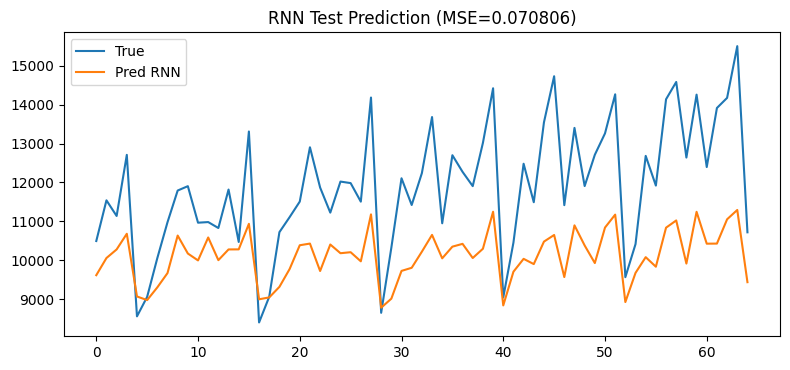

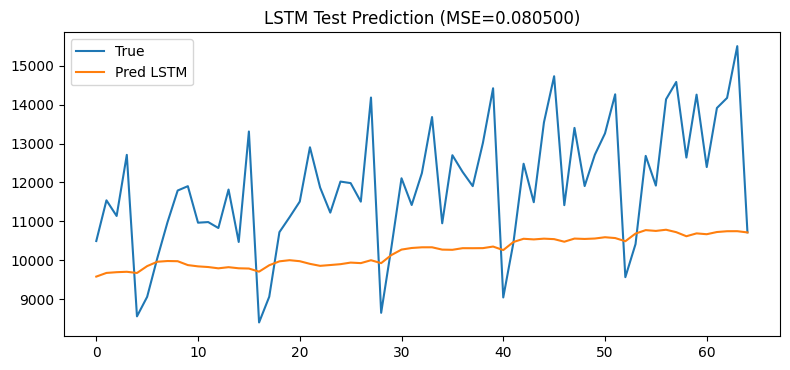

In [8]:
# 9. 역정규화 및 그래프 2개 (RNN/LSTM 각각)
y_test_inv    = scaler_ts.inverse_transform(y_test)
pred_rnn_inv  = scaler_ts.inverse_transform(pred_rnn)
pred_lstm_inv = scaler_ts.inverse_transform(pred_lstm)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3.8))
plt.plot(y_test_inv, label='True')
plt.plot(pred_rnn_inv, label='Pred RNN')
plt.title('RNN Test Prediction (MSE={:.6f})'.format(rnn_mse))
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 3.8))
plt.plot(y_test_inv, label='True')
plt.plot(pred_lstm_inv, label='Pred LSTM')
plt.title('LSTM Test Prediction (MSE={:.6f})'.format(lstm_mse))
plt.legend(); plt.tight_layout(); plt.show()


In [9]:
# 10. RNN/LSTM MSE 함께 출력
print(f"RNN Test MSE: {rnn_mse:.6f}")
print(f"LSTM Test MSE: {lstm_mse:.6f}")
better = 'RNN' if rnn_mse < lstm_mse else 'LSTM'
print(f"Better (lower MSE): {better}")


RNN Test MSE: 0.070806
LSTM Test MSE: 0.080500
Better (lower MSE): RNN
